In [1]:
import json

from matplotlib import pyplot as plt
import pandas as pd
import pickle
from s3fs.core import S3FileSystem

In [2]:
MODEL_DIR = "mids-capstone-irrigation-detection/models"

In [3]:
s3_file = S3FileSystem()

In [4]:
def f_scores(scores):
    precision = scores[6]
    recall = scores[7]
    if precision + recall == 0.0:
        return [0.0, 0.0]
    f1 = (2 * precision * recall) / (precision + recall)
    beta = 0.5
    f05 = ((1 + beta) * precision * recall) / (beta * precision + recall)
    return [f1, f05]
    

In [5]:
def load_results():
    for file in s3_file.listdir(MODEL_DIR):
        if file['type'] != 'directory':
            continue
        model_type = file["name"].split("/")[-1]
        data = []
        for result in s3_file.glob(file["name"]+"/*.json"):
            model_type = result.split("/")[-2]
            percent = result.split("/")[-1].split("_")[0]
            day = result.split("/")[-1].split("-")[-1].split(".")[0]
            r = json.load(s3_file.open(result))
            score = [model_type, int(day), int(percent), r["architecture"]] + r["score"] + f_scores(r["score"])
            data.append(score)
        df = pd.DataFrame(data)
        df.columns = ["model_type","day", "split_percent","architecture","loss","tp","fp","tn","fn","accuracy","precision","recall","auc","f1","f0.5"]
    df.split_percent = pd.to_numeric(df.split_percent, errors='coerce')
    return df


In [6]:
df = load_results()

In [7]:
df = df[df["day"] >= 20210214]
df.sort_values("split_percent")

,model_type,day,split_percent,architecture,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,f1,f0.5
19,supervised_baseline,20210215,1,Xception,0.738228,0.0,0.0,2002.0,1998.0,0.50050,0.000000,0.000000,0.668642,0.000000,0.000000
17,supervised_baseline,20210215,1,ResNet50,15.399220,253.0,166.0,1836.0,1745.0,0.52225,0.603819,0.126627,0.586941,0.209350,0.267630
15,supervised_baseline,20210215,1,ResNet101V2,6.496781,146.0,49.0,1951.0,1854.0,0.52425,0.748718,0.073000,0.762576,0.133030,0.183264
13,supervised_baseline,20210214,1,InceptionV3,1.047916,1959.0,1685.0,313.0,43.0,0.56800,0.537596,0.978521,0.835938,0.693943,0.632616
29,supervised_baseline,20210214,3,InceptionV3,0.404579,1644.0,247.0,1757.0,352.0,0.85025,0.869381,0.823647,0.927201,0.845897,0.853583
33,supervised_baseline,20210215,3,ResNet50,0.642376,1973.0,894.0,1111.0,22.0,0.77100,0.688176,0.988972,0.912204,0.811600,0.765817
35,supervised_baseline,20210215,3,Xception,0.569571,703.0,62.0,1934.0,1301.0,0.65925,0.918954,0.350798,0.894042,0.507765,0.596774
31,supervised_baseline,20210215,3,ResNet101V2,0.381174,1687.0,349.0,1651.0,313.0,0.83450,0.828585,0.843500,0.910095,0.835976,0.833498
5,supervised_baseline,20210214,10,InceptionV3,0.536028,1268.0,120.0,1872.0,740.0,0.78500,0.913545,0.631474,0.933173,0.746761,0.795150
7,supervised_baseline,20210215,10,ResNet101V2,0.285105,1892.0,303.0,1701.0,104.0,0.89825,0.861959,0.947896,0.947478,0.902887,0.888819


In [8]:
plot_df = df[["accuracy", "architecture", "split_percent"]]
plot_df = plot_df.pivot(index="split_percent", columns="architecture", values="accuracy").sort_values("split_percent", ascending=False)

In [9]:
plot_df

architecture,InceptionV3,ResNet101V2,ResNet50,Xception
split_percent,,,,
100,0.93925,0.93450,0.93275,0.93975
50,0.93550,0.90925,0.90650,0.93875
25,0.89875,0.92050,0.91900,0.92925
10,0.78500,0.89825,0.82050,0.89625
3,0.85025,0.83450,0.77100,0.65925
1,0.56800,0.52425,0.52225,0.50050


Text(0, 0.5, 'Accuracy')

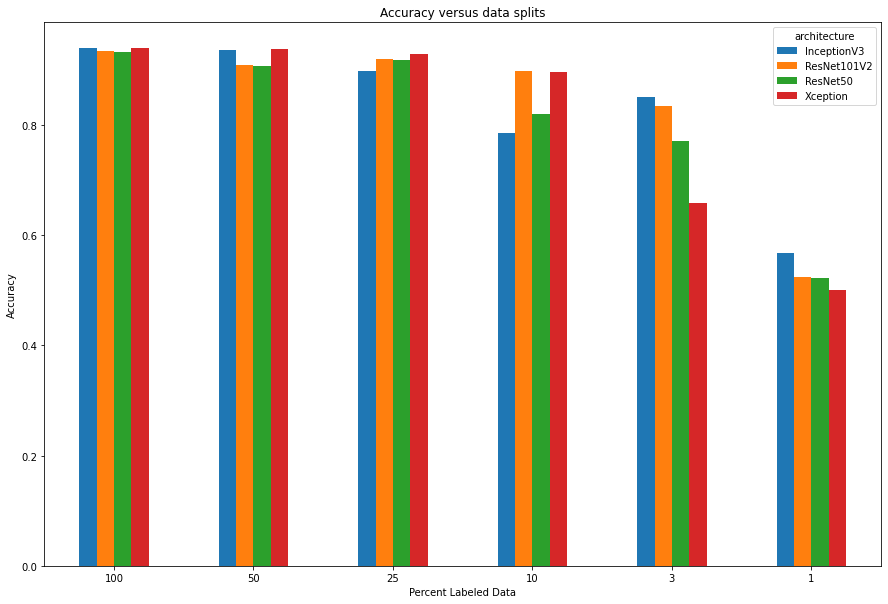

In [10]:
plot_df.plot(kind="bar", figsize=(15,10), rot=0)
plt.title("Accuracy versus data splits")
plt.xlabel("Percent Labeled Data")
plt.ylabel("Accuracy")